以下测试镜像

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import shutil

In [3]:
from pointer_utils import *

OpenCV version: 3.4.2
load yolov3-tiny-pointer.cfg backup_YOLO/yolov3-tiny-pointer_19000.weights
['dial', 'pointer']


In [4]:
frame,classIds,confidences,boxes = preprocess('20180119153156.jpg')

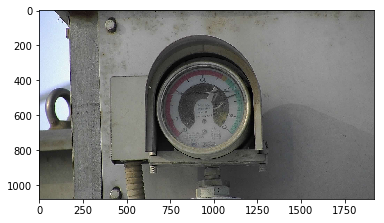

In [5]:
plt.imshow(frame)

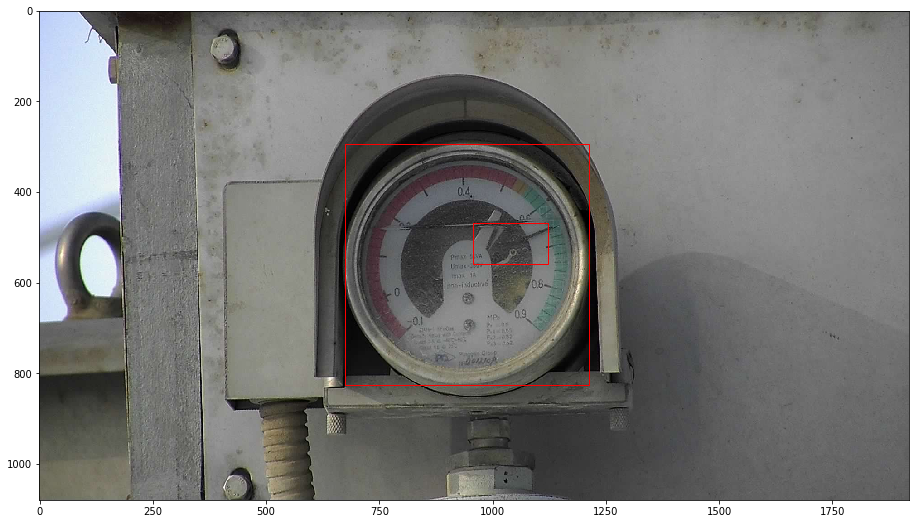

In [6]:
fig = plt.figure(figsize=(16,9))
show_detection2(frame, boxes)

In [8]:
frame,classIds,confidences,boxes = preprocess('20180119153156.jpg', transform=lambda frame:frame[:,::-1,:])

OpenCV version: 3.4.2
load yolov3-tiny-pointer.cfg backup_YOLO/yolov3-tiny-pointer_19000.weights
['dial', 'pointer']


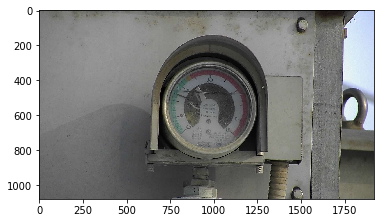

In [10]:
plt.imshow(frame)

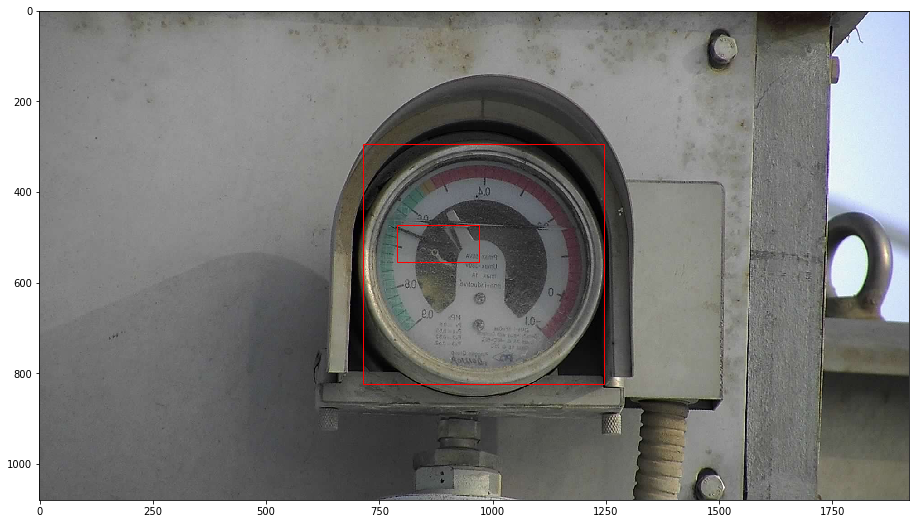

In [11]:
fig = plt.figure(figsize=(16,9))
show_detection2(frame, boxes)

In [34]:
def parse_pointer(frame, dial_box, pointer_box, alpha=0.5, scale_ratio=10):
    '''
    考虑两种较准，head校准，即在网络输出的pointer位置附近找边缘响应值最大者。
    tail较准，将网络预测的tail与dial的中心平均得，这个较准到底用不用看情况。
    '''
    pt = pointer_box
    
    if pt[0]+pt[2]//2 < dial_box[0]+dial_box[2]//2: # point to left
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point to top
            tail = (pt[0]+pt[2],pt[1]+pt[3])
            head = (pt[0],pt[1])
        else: # point to bottom
            tail = (pt[0]+pt[2],pt[1])
            head = (pt[0],pt[1]+pt[3])
    else: # point to right
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point top
            tail = (pt[0],pt[1]+pt[3])
            head = (pt[0]+pt[2],pt[1])
        else: # point to bottom
            tail = (pt[0],pt[1])
            head = (pt[0]+pt[2],pt[1]+pt[3])
    
    scale_x = dial_box[2] // scale_ratio
    scale_y = dial_box[3] // scale_ratio
    
    frame_gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    crop_gray = frame_gray[head[1]:head[1]+scale_y,head[0]-scale_x:head[0]]
    
    crop_blured = cv.GaussianBlur(crop_gray, (5,5), 10.0)
    sobelx8u = cv.Sobel(crop_blured, cv.CV_8U, 1, 0, ksize=5)
    sobely8u = cv.Sobel(crop_blured, cv.CV_8U, 0, 1, ksize=5)
    mag = np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float))
    
    minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(mag)
    
    head_new = (head[0]-scale_x+maxLoc[0], head[1]+maxLoc[1])
    
    dcx = dial_box[0]+dial_box[2]//2
    dcy = dial_box[1]+dial_box[3]//2
    tail_new = (int(tail[0]*(1-alpha)+dcx*alpha), int(tail[1]*(1-alpha)+dcy*alpha))
    
    return tail,head,tail_new,head_new

In [61]:
def parse_pointer_all(frame, dial_box, pointer_box):
    pt = pointer_box
    
    base_angle = np.arctan(pt[3]/pt[2])
    
    if pt[0]+pt[2]//2 < dial_box[0]+dial_box[2]//2: # point to left
        print('left')
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point to top
            print('top')
            tail = (pt[0]+pt[2],pt[1]+pt[3])
            head = (pt[0],pt[1])
            angle = -np.pi/2 - (np.pi/2-base_angle)
        else: # point to bottom
            print('bottom')
            tail = (pt[0]+pt[2],pt[1])
            head = (pt[0],pt[1]+pt[3])
            angle = -np.pi-base_angle
    else: # point to right
        print('right')
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point top
            print('top')
            tail = (pt[0],pt[1]+pt[3])
            head = (pt[0]+pt[2],pt[1])
            angle = -base_angle
        else: # point to bottom
            print('bottom')
            tail = (pt[0],pt[1])
            head = (pt[0]+pt[2],pt[1]+pt[3])
            angle = base_angle
            
    return angle, tail, head

def adjust_pointer():
    pass

In [24]:
dial_box = boxes[0]
pointer_box = boxes[1]

tail,head,tail_new,head_new = parse_pointer(frame, dial_box, pointer_box, alpha=0.0)

In [25]:
def process(frame, classIds, confidences, boxes, alpha=0.0, thickness=3, scale_ratio = 10):
    max_dial_idx, max_pointer_idx = extract_max(classIds, confidences)
    
    if max_dial_idx is None or max_pointer_idx is None:
        return frame.copy()
    
    dial_box = boxes[max_dial_idx]
    pointer_box = boxes[max_pointer_idx]
    
    tail, head, tail_new, head_new = parse_pointer(frame, dial_box, pointer_box, alpha = alpha)
    # new is poor than output directly come from darknet
    
    frame_line = frame.copy()
    cv.line(frame_line, tail, head, (255, 0, 255), thickness, 8);
    cv.line(frame_line, tail_new, head_new, (0, 255, 0), thickness, 8);
    
    if (pointer_box[0]+pointer_box[2]//2) > (dial_box[0]+dial_box[2]//2): # point to right
        angle = np.arctan((head[1] - tail[1])/(head[0]-tail[0])) # 注意y轴向下
    else:
        angle = np
    point = (angle/(np.pi/2)+1)*(0.74-0.6)+0.6
    
    cv.putText(frame_line, str(point), (head[0],head[1]-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
    
    #cv.rectangle()
    return frame_line

In [71]:
def process_all(frame, classIds, confidences, boxes, thickness=3):
    max_dial_idx, max_pointer_idx = extract_max(classIds, confidences)
    
    if max_dial_idx is None or max_pointer_idx is None:
        return frame.copy()
    
    dial_box = boxes[max_dial_idx]
    pointer_box = boxes[max_pointer_idx]
    
    angle, tail, head = parse_pointer_all(frame, dial_box, pointer_box)
    print(angle,tail,head)
    
    frame_line = frame.copy()
    cv.line(frame_line, tail, head, (255, 0, 255), thickness, 8);
    #cv.line(frame_line, tail_new, head_new, (0, 255, 0), thickness, 8);
    
    point = (angle/(np.pi/2))*(0.74-0.4) + 0.74
    
    cv.putText(frame_line, str(point), (head[0],head[1]-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
    
    return frame_line

In [30]:
np.arctan(-np.pi)

-1.2626272556789115

In [26]:
frame_line = process(frame, classIds, confidences, boxes)

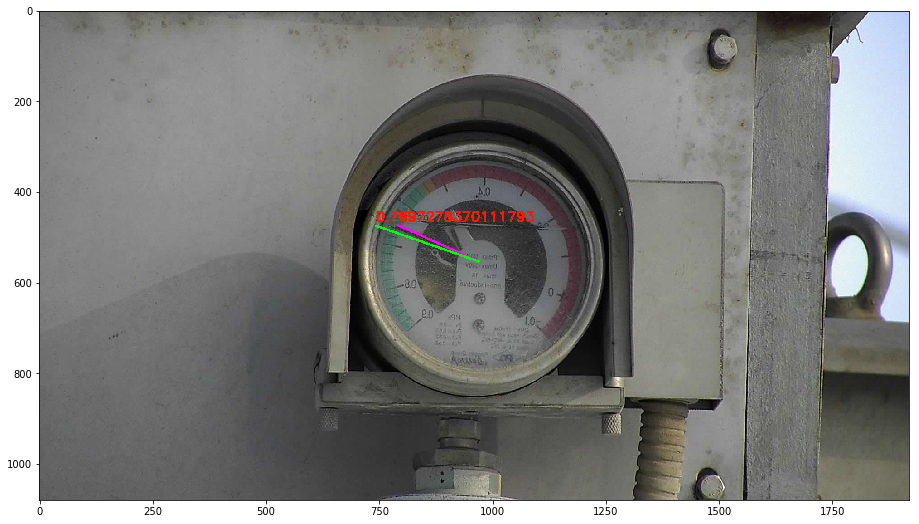

In [27]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

In [78]:
frame_line = process_all(frame, classIds, confidences, boxes)

left
top
-2.720808165753535 (971, 554) (790, 473)


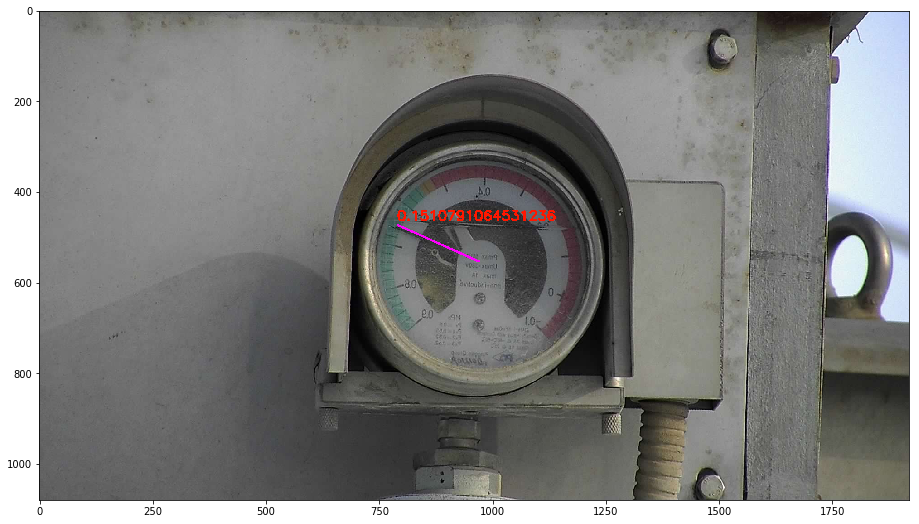

In [79]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

In [72]:
parse_pointer_all(frame,boxes[0],boxes[1])

left
top


(-2.720808165753535, (971, 554), (790, 473))

In [73]:
boxes[0],boxes[1]

([715, 294, 530, 530], [790, 473, 181, 81])

In [74]:
dial_box = boxes[0]
pointer_box = boxes[1]

In [75]:
    pt = pointer_box
    
    base_angle = np.arctan(pt[3]/pt[2])
    
    if pt[0]+pt[2]//2 < dial_box[0]+dial_box[2]//2: # point to left
        print('left')
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point to top
            print('top')
            tail = (pt[0]+pt[2],pt[1]+pt[3])
            head = (pt[0],pt[1])
            angle = -np.pi/2 - (np.pi/2-base_angle)
        else: # point to bottom
            print('bottom')
            tail = (pt[0]+pt[2],pt[1])
            head = (pt[0],pt[1]+pt[3])
            angle = -np.pi-base_angle
    else: # point to right
        print('right')
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point top
            print('top')
            tail = (pt[0],pt[1]+pt[3])
            head = (pt[0]+pt[2],pt[1])
            angle = -base_angle
        else: # point to bottom
            print('bottom')
            tail = (pt[0],pt[1])
            head = (pt[0]+pt[2],pt[1]+pt[3])
            angle = base_angle


left
top


In [76]:
base_angle,angle

(0.4207844878362583, -2.720808165753535)

In [77]:
point = (angle/(np.pi/2))*(0.74-0.4) + 0.74
point

0.1510791064531236

In [80]:
frame,classIds,confidences,boxes = preprocess('20180119153156.jpg')

right
top
-0.5014546443590654 (957, 560) (1123, 469)


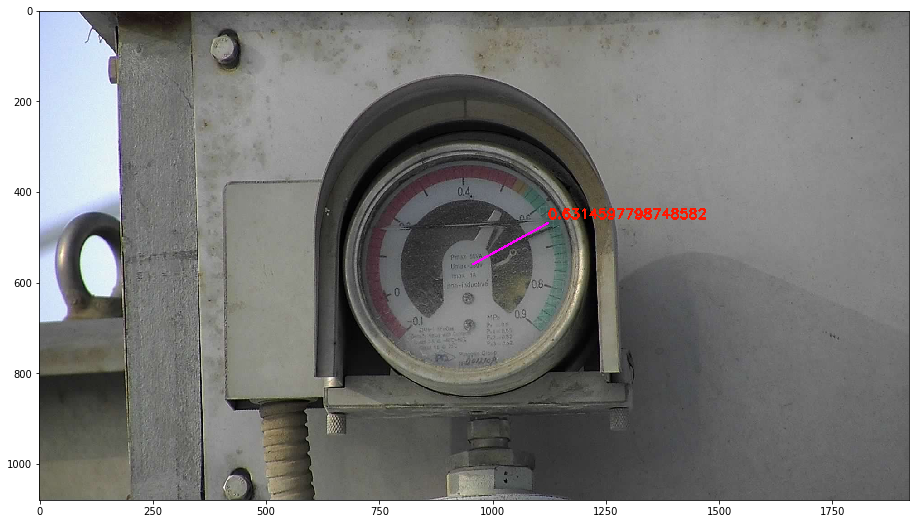

In [81]:
frame_line = process_all(frame, classIds, confidences, boxes)
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

True

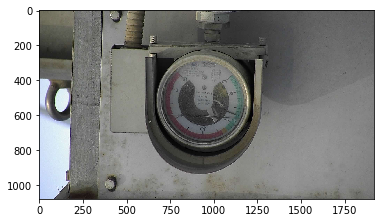

In [84]:
plt.imshow(frame[::-1])
cv.imwrite('mini_data/vflip.jpg',cv.cvtColor(frame[::-1], cv.COLOR_RGB2BGR))

True

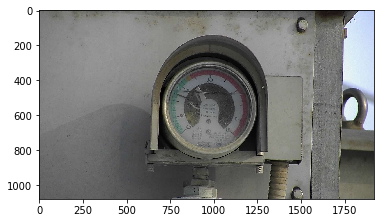

In [85]:
plt.imshow(frame[:,::-1,:])
cv.imwrite('mini_data/hflip.jpg',cv.cvtColor(frame[:,::-1,:], cv.COLOR_RGB2BGR))

In [148]:
def recover_loss(dial_box, center_point):
    
    
    # ommit left and use right and center point to recover left edge.
    if dial_box[0]+dial_box[2] - center_point[0] <= 0:
        return np.inf
    left_loss = (dial_box[0]+dial_box[2] - center_point[0])/dial_box[3]
    left_loss = max(left_loss,1/left_loss)
    
    if (center_point[0] - dial_box[0]) <= 0:
        return np.inf
    right_loss = (center_point[0] - dial_box[0])*2/dial_box[3]
    right_loss = max(right_loss, 1/right_loss)
    
    if (dial_box[1]+dial_box[3] - center_point[1]) <= 0:
        return np.inf
    top_loss = (dial_box[1]+dial_box[3] - center_point[1])*2/dial_box[2]
    top_loss = max(top_loss, 1/top_loss)

    if (center_point[1] - dial_box[1]) <= 0:
        return np.inf
    bottom_loss = (center_point[1] - dial_box[1])*2/dial_box[2]
    bottom_loss = max(bottom_loss,1/bottom_loss)
    
    print(left_loss, right_loss, top_loss, bottom_loss)
    return min(left_loss, right_loss) + min(top_loss, bottom_loss)

In [149]:
def parse_pointer_all(frame, dial_box, pointer_box):
    pt = pointer_box
    
    base_angle = np.arctan(pt[3]/pt[2])
    
    # cut adjust
    
    if dial_box[0] < frame.shape[1] * 0.1 or dial_box[0]+dial_box[2] > frame.shape[1]*0.9 or \
            dial_box[1] < frame.shape[0]*0.1 or dial_box[1]+dial_box[3] > frame.shape[0]*0.9:
        lefttop_loss = recover_loss(dial_box, (pointer_box[0], pointer_box[1]))
        leftbottom_loss = recover_loss(dial_box, (pointer_box[0], pointer_box[1]+pointer_box[3]))
        righttop_loss = recover_loss(dial_box, (pointer_box[0]+pointer_box[2], pointer_box[1]))
        rightbottom_loss = recover_loss(dial_box, (pointer_box[0]+pointer_box[2], pointer_box[1]+pointer_box[3]))
        
        tail_idx = np.argmin([lefttop_loss, leftbottom_loss, righttop_loss, rightbottom_loss])
        dir_idx = {0:3,1:2,2:1,3:0}[tail_idx]
        print([lefttop_loss, leftbottom_loss, righttop_loss, rightbottom_loss])
        
    else:
        if pt[0]+pt[2]//2 < dial_box[0]+dial_box[2]//2: # point to left
            if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point to top
                dir_idx = 0
            else:
                dir_idx = 1
        else:
            if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2:
                dir_idx = 2
            else:
                dir_idx = 3
    
    if dir_idx ==0:
        tail = (pt[0]+pt[2],pt[1]+pt[3])
        head = (pt[0],pt[1])
        angle = -np.pi/2 - (np.pi/2-base_angle)
    elif dir_idx == 1:
        tail = (pt[0]+pt[2],pt[1])
        head = (pt[0],pt[1]+pt[3])
        angle = -np.pi-base_angle
    elif dir_idx == 2:
        tail = (pt[0],pt[1]+pt[3])
        head = (pt[0]+pt[2],pt[1])
        angle = -base_angle
    elif dir_idx == 3:
        tail = (pt[0],pt[1])
        head = (pt[0]+pt[2],pt[1]+pt[3])
        angle = base_angle
    
    print(['lefttop', 'leftbottom', 'righttop', 'rightbottom'][dir_idx])
                    
    return angle, tail, head


In [170]:
def parse_pointer_all(frame, dial_box, pointer_box):
    pt = pointer_box
    
    base_angle = np.arctan(pt[3]/pt[2])
    
    # adjust cuted region
    
    print(dial_box)
    print(dial_box[1] > frame.shape[0] * 0.9)
    print(dial_box[3] < dial_box[2])
    
    if dial_box[0] < frame.shape[1] * 0.1 and dial_box[2] < dial_box[3]:
        dial_box = (dial_box[0] - (dial_box[3] - dial_box[2]), dial_box[1], dial_box[3], dial_box[3])
    elif (dial_box[0]+dial_box[2]) > frame.shape[1] * 0.9 and dial_box[2] < dial_box[3]:
        dial_box = (dial_box[0] , dial_box[1], dial_box[3], dial_box[3])
    elif dial_box[1] < frame.shape[0] * 0.1 and dial_box[3] < dial_box[2]:
        dial_box = (dial_box[0], dial_box[1] - (dial_box[2] - dial_box[3]), dial_box[2], dial_box[2])
    elif (dial_box[1]+dial_box[3]) > frame.shape[0] * 0.9 and dial_box[3] < dial_box[2]:
        dial_box = (dial_box[0], dial_box[1], dial_box[2], dial_box[2])
        
    print(dial_box)
    
    if pt[0]+pt[2]//2 < dial_box[0]+dial_box[2]//2: # point to left
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2: # point to top
            dir_idx = 0
        else:
            dir_idx = 1
    else:
        if pt[1]+pt[3]//2 < dial_box[1]+dial_box[3]//2:
            dir_idx = 2
        else:
            dir_idx = 3
    
    if dir_idx ==0:
        tail = (pt[0]+pt[2],pt[1]+pt[3])
        head = (pt[0],pt[1])
        angle = -np.pi/2 - (np.pi/2-base_angle)
    elif dir_idx == 1:
        tail = (pt[0]+pt[2],pt[1])
        head = (pt[0],pt[1]+pt[3])
        angle = -np.pi-base_angle
    elif dir_idx == 2:
        tail = (pt[0],pt[1]+pt[3])
        head = (pt[0]+pt[2],pt[1])
        angle = -base_angle
    elif dir_idx == 3:
        tail = (pt[0],pt[1])
        head = (pt[0]+pt[2],pt[1]+pt[3])
        angle = base_angle
    
    print(['lefttop', 'leftbottom', 'righttop', 'rightbottom'][dir_idx])
                    
    return angle, tail, head


In [171]:
frame, classIds, confidences, boxes = preprocess('20180514110756.jpg')

In [172]:
thickness = 3

In [173]:
    max_dial_idx, max_pointer_idx = extract_max(classIds, confidences)
    
    #if max_dial_idx is None or max_pointer_idx is None:
    #    return frame.copy()
    
    dial_box = boxes[max_dial_idx]
    pointer_box = boxes[max_pointer_idx]
    
    angle, tail, head = parse_pointer_all(frame, dial_box, pointer_box)
    print(angle,tail,head)
    
    frame_line = frame.copy()
    cv.line(frame_line, tail, head, (255, 0, 255), thickness, 8);
    #cv.line(frame_line, tail_new, head_new, (0, 255, 0), thickness, 8);
    
    point = (angle/(np.pi/2))*(0.74-0.4) + 0.74
    
    cv.putText(frame_line, str(point), (head[0],head[1]-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8);

[517, 591, 572, 466]
False
True
(517, 591, 572, 572)
righttop
-0.5358112379604637 (812, 885) (1004, 771)


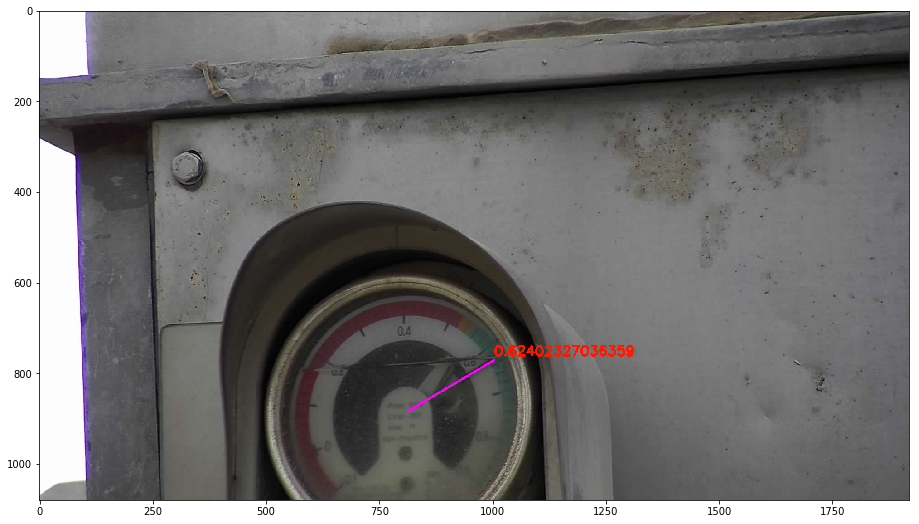

In [174]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

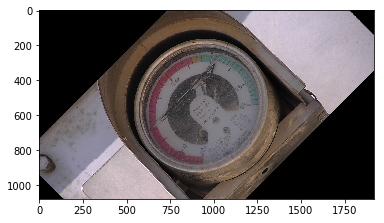

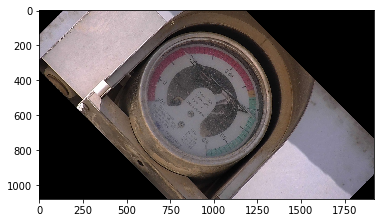